## Introduction

Since the October 7th terrorist attack on Israel by Palestinians, antisemitism and anti-Zionism has spread like wildfire throughout the world. One place where antisemitism has skyrocketed in recent years is on American college campuses. This alarming spread has been linked to the group "Faculty for Justice in Palestine" (FJP), which has over 170 chapters across the U.S. Behind the creation of this faculty group is the Palestinian Campaign for the Academic and Cultural Boycott of Israel (PACBI), a group linked to five U.S. designated terrorist organizations including Hamas and Palestinian Islamic Jihad.

In an effort to combat the spread of antisemitism on American college campuses, the AMCHA Initiative recently released the Anti-Zionist Faculty (AZF) Barometer. This comprehensive, one-of-a-kind tool was designed to help people "evaluate the pervasiveness of anti-Zionist faculty at hundreds of U.S. colleges and universities." Schools with active FJP chapters report higher rates of violent antisemitic activity, making the group's presence a significant factor in a university's AZF Barometer ranking.

In what follows, we will explore this fascinating new tool via data analysis in a Jupyter Notebook. To do so, we will first collect relevant data from the AMCHA Initiative website via web scraping. We will then prepare the scraped data in a way that allows us to explore the data and to start asking interesting questions. Finally, we will do some basic statistics on the data in order to demonstrate the extent of antisemitism on college campuses in America.

## Data collection and preparation

### Webscraping data

We will be using Selenium and BeautifulSoup for gathering our data from the webpage.

In [ ]:
# uncomment below if needed to install 
#!pip install selenium beautifulsoup4

We will need the following imports for this purpose.

In [1]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from bs4 import BeautifulSoup

We want to set up a `webdriver` for us to control a Chrome browser. We use this webdriver to tell Chrome to visit the AMCHA Initiative webpage where the Anti-Zionist Faculty Barometer is located. The web address we provide our webdriver also contains special instructions to display 1000 entries per page and to load the first page of the results. This will allow us to acquire all of the webpage's content in one fell swoop.

In [2]:
driver = webdriver.Chrome()

driver.get('https://amchainitiative.org/azf-barometer/?ppwp=1#anti-zionist-faculty-barometer/?ppwp=1&view_433_per_page=1000&view_433_page=1')

Next, we retrieve the webpage's content and hand it over to `BeautifulSoup` for processing, and we let it know we will be parsing HTML data. We can then print the parsed content, showing the structure and data of the webpage.

Note: Please make sure the webdriver is fully loaded before running the next cell, or we will have missing content. Also, be sure to remove `%%capture` if you want to examine the contents of the `soup`.

In [3]:
%%capture

page_source = driver.page_source
soup = BeautifulSoup(page_source, 'html.parser')

soup

Our `soup` contains the entire HTML content of the webpage. We can now extract the specific information from the webpage that we want to work with. We are particularly interested in the tabular data, but first let's display all of the rich text data from the webpage. Of course, we can read this information on the webpage itself, but we can also do so here. We can use the `find_all()` method to extract all sections of the webpage that have rich text.

In [4]:
text_info = soup.find_all('div', class_="fl-rich-text")
text_info[0]

<div class="fl-rich-text">
<p><em>Explore the Anti-Zionist Faculty (AZF) Barometer, a powerful ranking tool that measures the prevalence of anti-Zionist faculty on U.S. campuses, empowering stakeholders to advocate for stronger protections against the normalization of academic antisemitism.</em></p>
<p style="text-align: center;">For further information, see the <a href="https://amchainitiative.org/wp-content/uploads/2024/12/Guide-to-AZM-Barometer.pdf">Guide to the AZF Barometer</a></p>
<p style="text-align: center;"><a href="#search">Jump to Search</a></p>
</div>

We have now extracted all sections of the webpage that have the tag `<div class="fl-rich-text">`. Each section is contained in a list, and we display the first one above. Notice how the first line is the tag we told `soup` to find. Also, notice how the second line contains textual information after the tags `<p><em>`. This is the information we want, but it would be nice to see it displayed without all the HTML, just like we do when we go to the actual webpage. To do this, we just have to move through each section in our list one by one and tell it that we only want to display the rich text.

In [5]:
for section in text_info:
    print(section.text)


Explore the Anti-Zionist Faculty (AZF) Barometer, a powerful ranking tool that measures the prevalence of anti-Zionist faculty on U.S. campuses, empowering stakeholders to advocate for stronger protections against the normalization of academic antisemitism.
For further information, see the Guide to the AZF Barometer
Jump to Search


An Overview of the Anti-Zionist Faculty (AZF) Barometer


About the Barometer:
The Anti-Zionist Faculty (AZF) Barometer provides a ranking system to measure the presence and activity of anti-Zionist faculty on U.S. college campuses. AMCHA Initiative’s research shows a strong correlation between anti-Zionist faculty presence and the severity of campus antisemitism, including physical assaults, threats, and harassment targeting Jewish students.
The rise of Faculty for Justice in Palestine (FJP), a network of over 170 campus chapters established after Hamas' October 7, 2023 attack, has exacerbated this issue. FJP was launched in response to a call from the US

We have now extracted and displayed all of the rich text from the webpage. Of particular interest for our purposes is the information about the different rankings and their meanings. We will need to know this information later on to interpret the tabular data.

Let's now extract the tabular data, which consists of rows and columns, from the webpage. This is the data we need to do our statistical analysis. Once again, be sure to remove `%%capture` if you want to examine the entire `table`.

In [6]:
%%capture

table = soup.find('div', class_='kn-table-wrapper')
table

We can display all the column header names like this: 

In [7]:
# table header column names 
for th in table.find_all('th'):
    print(th.text.strip())

College/University
School Rankings
# Faculty Boycotters
FJP (Y/N)
FJP Events & Statements
Depts w/Statements (Y/N)
View More


But in order to be able to do statistical analysis with the data from the webpage, we need to structure it in a way that can be easily processed and analyzed by a computer. We can do this by creating our own table or dataframe using the Pandas library.

### Setting up the dataframe

We begin by setting up the dataframe with our column header names. First, let's put all column header names into a list. Then, we can import Pandas and easily add the columns we want to a Pandas dataframe.

In [8]:
column_headers = []

for th in table.find_all('th'):
    column_headers.append(th.text.strip())

column_headers

['College/University',
 'School Rankings',
 '# Faculty Boycotters',
 'FJP (Y/N)',
 'FJP Events & Statements',
 'Depts w/Statements (Y/N)',
 'View More']

In [9]:
import pandas as pd 

In [10]:
df = pd.DataFrame(columns=column_headers[:-1])
df

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N)


We've added every column but the last to our dataframe and displayed our dataframe `df`, which currently has just our header names. The next thing we want to do is to scrape each row of data and add it to our dataframe.

### Scraping each row of data

In the HTML we scraped from the webpage, each row in our table begins with a `<tr>` tag for 'table row', and we can find them all in our `table` object, again by using `find_all()`. However, we will need to skip the first `<tr>` which is the row of header names we've already added to our dataframe `df`. After finding and storing all `<tr>` tags in a `data` object, we display the first row. Notice the `<tr>` tag in the first line.

In [11]:
data = table.find_all('tr')[1:]
data[0]

<tr id="674f85e1d516bc02d4922901">
<td class="field_246 cell-edit" data-column-index="0" data-field-key="field_246" style="font-weight: bold; "><span class="col-0">
<span class="5b4bd8b22d7f5f28788b16d3">New York University (NYU)</span>
</span></td>
<td class="field_294 cell-edit" data-column-index="1" data-field-key="field_294" style="text-align: center; background-color:#c30b01; font-weight: bold; color:#ffffff; "><span class="col-1">
5 - Extreme
  </span></td>
<td class="field_249 cell-edit" data-column-index="2" data-field-key="field_249" style="text-align: center; "><span class="col-2">
123
  </span></td>
<td class="field_252 cell-edit" data-column-index="3" data-field-key="field_252" style="text-align: center; "><span class="col-3">
Yes
  </span></td>
<td class="field_259 cell-edit" data-column-index="4" data-field-key="field_259" style="text-align: center; "><span class="col-4">
44
  </span></td>
<td class="field_261 cell-edit" data-column-index="5" data-field-key="field_261" st

Again, we can display just the text (for the first row) without all that distracting HTML. 

In [13]:
row_data = data[0].find_all('td')
for data_point in row_data[:-1]:
    print(data_point.text.strip())

New York University (NYU)
5 - Extreme
123
Yes
44
Yes


Above are the data points for our first row of data in our table, one data point for each one of our columns. We will iterate through each row of our `data` object, extract all data points of each row, and add each data point of a row to a list of `school_data`. We will then add this list of school data to a master list of all `schools`. Afterwards, we can inspect the first 5 schools in our master list. 

In [14]:
schools = []
for row in data: 
    row_data = row.find_all('td')
    school_data = [data_point.text.strip() for data_point in row_data[:-1]]
    schools.append(school_data)
schools[:5]

[['New York University (NYU)', '5 - Extreme', '123', 'Yes', '44', 'Yes'],
 ['University of Minnesota Twin Cities',
  '5 - Extreme',
  '35',
  'Yes',
  '54',
  'Yes'],
 ['Columbia University/Barnard College',
  '5 - Extreme',
  '72',
  'Yes',
  '27',
  'Yes'],
 ['University of California Santa Cruz (UCSC)',
  '5 - Extreme',
  '39',
  'Yes',
  '40',
  'Yes'],
 ['University of Washington', '5 - Extreme', '76', 'Yes', '21', 'Yes']]

We can determine the number of schools in our master list by getting the length of the master list.

In [15]:
num_of_schools = len(schools)
print("Number of schools: " + str(num_of_schools))

Number of schools: 727


We are now ready to add 727 rows of data to our dataframe.

### Construct dataframe

Let's examine our dataframe so far again, which currently has only the column header names.

In [16]:
df

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N)


Each school in our master list of `schools` will be a row of our dataframe. We move school by school through our master list of `schools`, adding each school's row of data to our dataframe. Once complete, we inspect the the first 5 rows of our dataframe as well as the number of rows in our dataframe, which should be the same as the number of schools in our master list.

In [17]:
for school in schools:
    length = len(df)

    df.loc[length] = school
df.head()

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N)
0,New York University (NYU),5 - Extreme,123,Yes,44,Yes
1,University of Minnesota Twin Cities,5 - Extreme,35,Yes,54,Yes
2,Columbia University/Barnard College,5 - Extreme,72,Yes,27,Yes
3,University of California Santa Cruz (UCSC),5 - Extreme,39,Yes,40,Yes
4,University of Washington,5 - Extreme,76,Yes,21,Yes


In [18]:
print("Number of rows in the dataframe: " + str(len(df)))

Number of rows in the dataframe: 727


Our dataframe now consists of all 727 school's data in our master list. The first five rows all have a school ranking of '5 - Extreme.' We can inspect the last 5 rows of our dataframe as well.

In [19]:
df.tail()

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N)
722,Xavier University,0 - Negligible,0,No,0,No
723,Yeshiva University,0 - Negligible,0,No,0,No
724,Youngstown State University,0 - Negligible,0,No,0,No
725,Los Angeles Pierce College (Pierce College),0 - Negligible,0,No,0,No
726,Washington & Jefferson College,0 - Negligible,1,No,,No


The last five rows all have a school ranking of '0 - Negligible.' It appears our dataframe is in descending order, beginning with schools ranked highest, that is with the highest number of anti-Zionist faculty.

Let's view some metadata about our newly constructed dataframe.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   College/University        727 non-null    object
 1   School Rankings           727 non-null    object
 2   # Faculty Boycotters      727 non-null    object
 3   FJP (Y/N)                 727 non-null    object
 4   FJP Events & Statements   727 non-null    object
 5   Depts w/Statements (Y/N)  727 non-null    object
dtypes: object(6)
memory usage: 39.8+ KB


From the above, we can see that our dataframe has 6 columns (to be expected) and that each column has 727 `non_null` values. This means that all rows have a data point for each one of the columns, and there are no data points missing from our dataframe. Under the column named `Dtype` above (not in our dataframe), the data type of each data point in every column is of type `object`. This will cause problems when we want to do statistics with our data later on. In order to perform mathematical operations on our data, we must convert our data to be of the correct data type.

To do this, we will re-structure our data frame by splitting the column `School Rankings` into two separate columns, one with just the number (e.g., 5) and one with just the text (e.g., 'Extreme'). 

In [21]:
school_rankings = []
for ranking in df['School Rankings']:
    school_ranking = ranking.split('-')
    school_ranking = (int(school_ranking[0].strip()), school_ranking[1].strip())
    school_rankings.append(school_ranking)

df['School Rankings #'] = [ranking[0] for ranking in school_rankings]
df['School Rankings Text'] = [ranking[1] for ranking in school_rankings]
df.head()

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N),School Rankings #,School Rankings Text
0,New York University (NYU),5 - Extreme,123,Yes,44,Yes,5,Extreme
1,University of Minnesota Twin Cities,5 - Extreme,35,Yes,54,Yes,5,Extreme
2,Columbia University/Barnard College,5 - Extreme,72,Yes,27,Yes,5,Extreme
3,University of California Santa Cruz (UCSC),5 - Extreme,39,Yes,40,Yes,5,Extreme
4,University of Washington,5 - Extreme,76,Yes,21,Yes,5,Extreme


From the above, you can see that we have two new columns. Let's view this reformatted dataframe's metadata as well. 

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 727 entries, 0 to 726
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   College/University        727 non-null    object
 1   School Rankings           727 non-null    object
 2   # Faculty Boycotters      727 non-null    object
 3   FJP (Y/N)                 727 non-null    object
 4   FJP Events & Statements   727 non-null    object
 5   Depts w/Statements (Y/N)  727 non-null    object
 6   School Rankings #         727 non-null    int64 
 7   School Rankings Text      727 non-null    object
dtypes: int64(1), object(7)
memory usage: 51.1+ KB


We can now see that we have 8 columns (instead of 6), as we have successfully added 2 more columns to our dataframe. Furthermore, we can see that one of the new columns `School Rankings #` is of data type `int64`, the data type we need to perform mathematical operations. In fact, we want all columns with numerical data like `# Faculty Boycotters` and `FJP Events & Statements` to also be of type `int64`, so let's convert these columns now, and inspect our dataframe info once more. 

In [24]:
df['# Faculty Boycotters'] = df['# Faculty Boycotters'].astype(int)
df['FJP Events & Statements'] = df['FJP Events & Statements'].astype(int)

ValueError: invalid literal for int() with base 10: ''

Uh-oh. We received an error. The error message above tells us that the column `FJP Events & Statements` contains non-numeric values, such as empty strings (''), which cannot be converted to type `int64`. To solve this, we can create a new dataframe with rows which contain only numeric values in this column (i.e., no empty values).

In [25]:
filtered_df = df[df['FJP Events & Statements'].apply(lambda x: str(x).isdigit())].copy()
filtered_df['FJP Events & Statements'] = filtered_df['FJP Events & Statements'].astype(int)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 726 entries, 0 to 725
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   College/University        726 non-null    object
 1   School Rankings           726 non-null    object
 2   # Faculty Boycotters      726 non-null    int64 
 3   FJP (Y/N)                 726 non-null    object
 4   FJP Events & Statements   726 non-null    int64 
 5   Depts w/Statements (Y/N)  726 non-null    object
 6   School Rankings #         726 non-null    int64 
 7   School Rankings Text      726 non-null    object
dtypes: int64(3), object(5)
memory usage: 51.0+ KB


Viola. We now have a new filtered dataframe `filtered_df`, where the offending row has been excluded. As you can see, we now have 726 entries. Our data is now ready to do statistics. 

We can use `describe()` to see the `count`, `mean`, `standard deviation`, `minimum`, `quartiles`, and `maximum` of each column with numerical data.

In [26]:
filtered_df.describe()

,# Faculty Boycotters,FJP Events & Statements,School Rankings #
count,726.000000,726.000000,726.000000
mean,6.286501,2.286501,0.902204
std,16.145391,6.452202,1.470659
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,4.000000,0.000000,2.000000
max,184.000000,54.000000,5.000000


We can also see what the top 10 universities with the most faculty boycotters are.

In [27]:
ten_most_boycotters = df.sort_values(by='# Faculty Boycotters', ascending=False)
ten_most_boycotters.head(10)

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N),School Rankings #,School Rankings Text
104,"California State Polytechnic University, Humbo...",3 - Significant,184,Yes,1,No,3,Significant
67,Harvard University,3 - Significant,152,Yes,8,No,3,Significant
0,New York University (NYU),5 - Extreme,123,Yes,44,Yes,5,Extreme
63,Pratt Institute,3 - Significant,105,Yes,13,No,3,Significant
40,Brown University,4 - Severe,104,Yes,2,Yes,4,Severe
10,Rutgers University - New Brunswick,5 - Extreme,96,Yes,14,Yes,5,Extreme
221,Western Washington University,1 - Minimal,87,No,0,No,1,Minimal
6,University of California Los Angeles (UCLA),5 - Extreme,86,Yes,18,Yes,5,Extreme
4,University of Washington,5 - Extreme,76,Yes,21,Yes,5,Extreme
17,Northwestern University,5 - Extreme,76,Yes,10,Yes,5,Extreme


This is interesting. Most of these schools have a ranking of 3 or greater, with one exception. Western Washington University has a large number of faculty boycotters but a minimal ranking, suggesting that `# Faculty Boycotters` alone does not result in a high ranking. In fact, they are the one university of the ten above without its own FJP chapter. 

Let's see how many American colleges in total have an FJP chapter.

In [28]:
fjp_counts = df['FJP (Y/N)'].value_counts()
fjp_counts

FJP (Y/N)
No     546
Yes    181
Name: count, dtype: int64

The AMCHA Initiative website states there are over 170 chapters across the U.S. There appear to be even more today. 

## Data analysis and visualization

Another thing we might be interested in is the number of schools that have each ranking (0-5). We display this information below.

In [29]:
ranking_counts = df['School Rankings #'].value_counts().sort_index()
print(ranking_counts)

School Rankings #
0    486
1     42
2     77
3     59
4     33
5     30
Name: count, dtype: int64


As we can see, there are 486 schools with a ranking of 0 ('Negligible'), 42 with a ranking of 1 ('Minimal'), and so on and so forth. 

We can also visualize this information in a bar chart.

In [30]:
import matplotlib.pyplot as plt

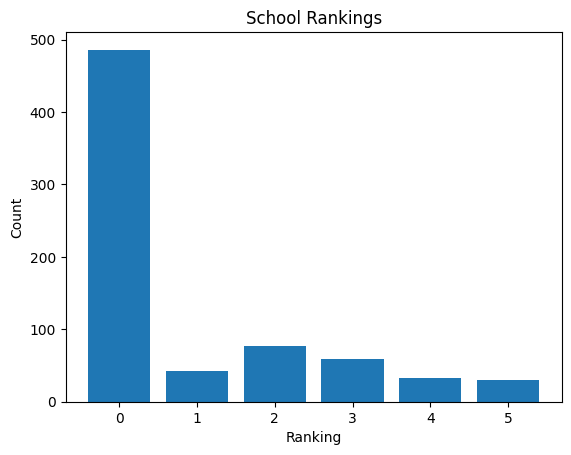

In [31]:
plt.bar(ranking_counts.index, ranking_counts.values)
plt.xlabel('Ranking')
plt.ylabel('Count')
plt.title('School Rankings')
plt.show()

This looks nice. However, we might want the colors of each bar in the chart to match the colors used on the actual webpage for each ranking, e.g., red for 5, green for 0, etc.

We will obtain this information from the HTML as before. We are interested in all data points that have styling information, in particular ones with a `background-color`.

In [32]:
td_tags = soup.find_all('td', style=True)
td_tags[1]

<td class="field_294 cell-edit" data-column-index="1" data-field-key="field_294" style="text-align: center; background-color:#c30b01; font-weight: bold; color:#ffffff; "><span class="col-1">
5 - Extreme
  </span></td>

We can extract all the background colors we need with the following code below: 

In [33]:
background_colors = []
for td in td_tags:
    styles = td['style']
    styles = styles.split(';')
    for style in styles:
        if 'background-color' in style:
            background_color = style.split(':')[1]
            if background_color not in background_colors:
                background_colors.append(background_color)

background_colors.reverse()
print(background_colors)

['#99ba00', '#d4d200', '#eada00', '#deaf00', '#d96700', '#c30b01']


We now have a list of all hex color codes used in the table of our webpage. We can use this list of `background_colors` to re-create our bar chart. 

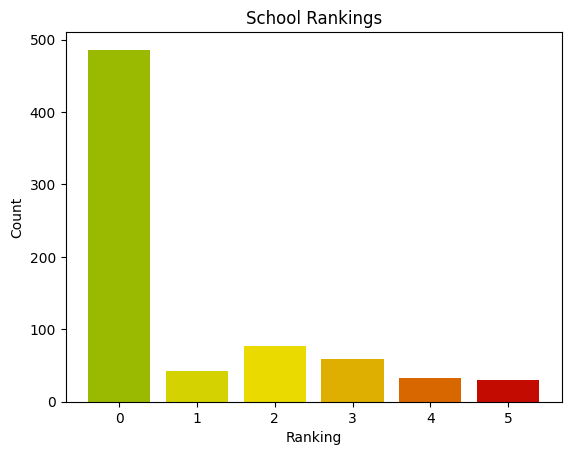

In [34]:
plt.bar(ranking_counts.index, ranking_counts.values, color=background_colors)
plt.xlabel('Ranking')
plt.ylabel('Count')
plt.title('School Rankings')
plt.show()

We can also display our data with the highest (worst) rank on the left, and the lowest (best) rank on the right. This feels more in line with the order of data on the actual webpage, with higher (worst) ranks at the top and lower (best) ranks at the bottom. 

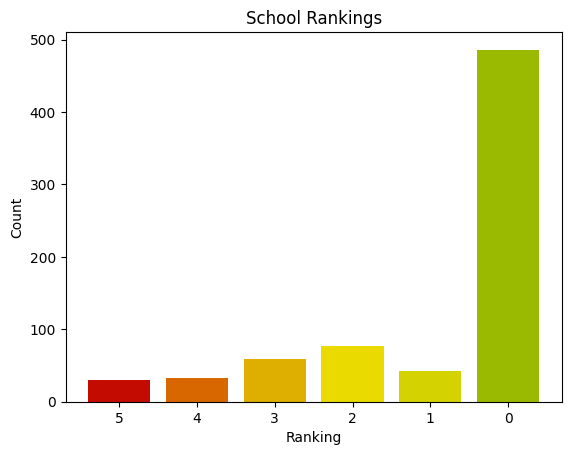

In [35]:
plt.bar(ranking_counts.index, ranking_counts.values, color=background_colors)
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.xlabel('Ranking')
plt.ylabel('Count')
plt.title('School Rankings')
plt.show()


From this chart, we can see the distribution of schools organized by school ranking. It appears that the majority of schools have a favorable 0/"Negligible" ranking.

We might also be interested in exploring the presence of anti-Zionist faculty in a particular state, e.g., Florida. A simple way we can do this is by extracting all schools with the word 'Florida' (for instance) from our dataframe. (Indeed, there are better methods, as this will potentially leave out schools that do not have the state's name in them). To do so, we create a new dataframe `florida` with the same column header names, but this time we only add rows with the word 'Florida' in column `College/University`. We do this below, and then inspect the dataframe. 

In [36]:
florida = pd.DataFrame(columns=df.columns)
florida

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N),School Rankings #,School Rankings Text


In [37]:
for index, row in df.iterrows():
    if 'Florida' in row['College/University']:
        length = len(florida)
        florida.loc[length] = row

In [38]:
florida_ranking_counts = florida['School Rankings #'].value_counts().sort_index()
all_ranks = range(0,6)  # Full range of ranks
florida_ranking_counts = florida_ranking_counts.reindex(all_ranks, fill_value=0)  # Fill missing ranks with 0
florida_ranking_counts

School Rankings #
0    11
1     1
2     0
3     1
4     0
5     0
Name: count, dtype: int64

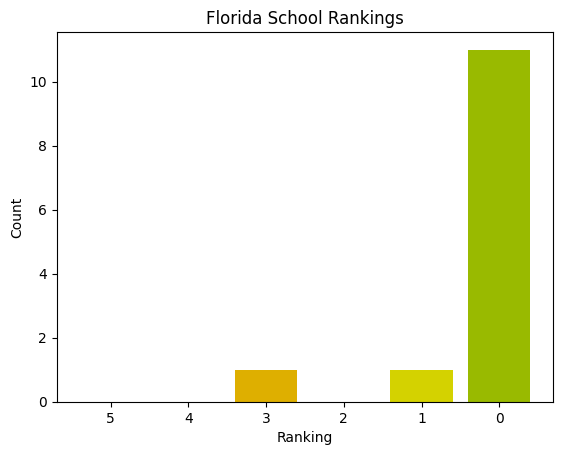

In [39]:
plt.bar(florida_ranking_counts.index, florida_ranking_counts.values, color=background_colors)
plt.gca().invert_xaxis()  # Reverse the x-axis
plt.xlabel('Ranking')
plt.ylabel('Count')
plt.title('Florida School Rankings')
plt.show()

As we can see, the majority of schools in Florida have a favorable rating, with only 2 schools with an unfavorable rating. 

Looks like Florida has a good grip on its antisemitism. 

If we want to find out which schools have an unfavorable rating, again we can do so by examining our dataframe (e.g., `florida`). 

In [40]:
florida

,College/University,School Rankings,# Faculty Boycotters,FJP (Y/N),FJP Events & Statements,Depts w/Statements (Y/N),School Rankings #,School Rankings Text
0,"University of Florida, Gainesville",3 - Significant,12,Yes,8,No,3,Significant
1,Florida International University,1 - Minimal,7,No,0,No,1,Minimal
2,Florida State University,0 - Negligible,5,No,0,No,0,Negligible
3,University of South Florida,0 - Negligible,4,No,0,No,0,Negligible
4,Eastern Florida State College,0 - Negligible,0,No,0,No,0,Negligible
5,Florida Atlantic University,0 - Negligible,0,No,0,No,0,Negligible
6,Florida Gulf Coast University,0 - Negligible,0,No,0,No,0,Negligible
7,Florida Institute Of Technology,0 - Negligible,1,No,0,No,0,Negligible
8,Florida Keys Community College,0 - Negligible,0,No,0,No,0,Negligible
9,Florida Southern College,0 - Negligible,0,No,0,No,0,Negligible


Uh-oh. It looks like my Alma Mater has significant anti-Zionist faculty presence and activity. As we can see, the University of Florida is the only school in our `florida` dataframe that has an FJP chapter. In addition, there have been 8 FJP events and statements at this school. There is clearly more work to be done to ensure the safety of Jewish students at the University of Florida.

Of course, there are many other interesting things about our data and many more interesting questions we could ask to explore. Please feel free to play around with the data yourself and report back on your findings. 